Import libraries and MNIST dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install tqdm


In [3]:
!unzip -u -q /content/drive/MyDrive/mydata/efigi-1.6.zip

In [4]:
import os
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from PIL import Image

import plotly.express as px

from sklearn.manifold import TSNE

np.random.seed(1234)

class EfigiDataset(Dataset):
  def __init__(self, data_dir, transform = None):
    self.data_dir = data_dir
    self.transform = transform
    self.file_list = os.listdir(data_dir)

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self,idx):
    file_name = self.file_list[idx]
    image_path = os.path.join(self.data_dir, file_name)
    image = Image.open(image_path)#.convert("RGB")

    if self.transform:
      image = self.transform(image)

    return image

data_dir = "/content/efigi-1.6/png"

efigi_transform = transforms.Compose([ #//(image), encode(img)
transforms.Resize((112, 112)), # <------ images resized!!! needs fixing
#transforms.Grayscale(num_output_channels=1), # <----- images flattened to single channel!
transforms.ToTensor(),
])

custom_dataset = EfigiDataset(data_dir, transform = efigi_transform)


train_val_data, test_dataset = random_split(custom_dataset, [4000, 458])

train_dataset, val_dataset = random_split(train_val_data, [3800, 200])
batch_size=256


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


Define Convolutional Autoencoder

In [5]:
class Encoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 128, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, 3 * 3 * 128),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(128, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3,
            stride=2, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3,
            stride=2, padding=1,output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3,
            stride=2, padding=0,output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
            padding=0, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2,
            padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x

 Initialize Loss function and the optimizer

In [6]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the bottleneck size of the two networks
d = 2

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1152, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (10): BatchNorm2d(8, 

Train and evaluate model

In [7]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in dataloader: # Nikos: I remoted the _ OLD: with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [8]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch in dataloader: #Nikos: removed ,_
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [9]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    #targets = test_dataset.targets.numpy() # no targets in this task!
    #t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i].to(device).reshape(1,3,112,112)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = torch.clip(decoder(encoder(img)), 0, 1)
      plt.imshow(torch.swapaxes(img.cpu().squeeze(), 0,2).numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(torch.swapaxes(rec_img.cpu().squeeze(),0,2).numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

	 partial train loss (single batch): 0.016168
	 partial train loss (single batch): 0.016984
	 partial train loss (single batch): 0.016215
	 partial train loss (single batch): 0.015939
	 partial train loss (single batch): 0.016233
	 partial train loss (single batch): 0.015767
	 partial train loss (single batch): 0.015362
	 partial train loss (single batch): 0.014968
	 partial train loss (single batch): 0.015791
	 partial train loss (single batch): 0.015375
	 partial train loss (single batch): 0.014866
	 partial train loss (single batch): 0.014794
	 partial train loss (single batch): 0.013899
	 partial train loss (single batch): 0.014287
	 partial train loss (single batch): 0.014857

 EPOCH 1/50 	 train loss 0.015433752909302711 	 val loss 0.014739195816218853


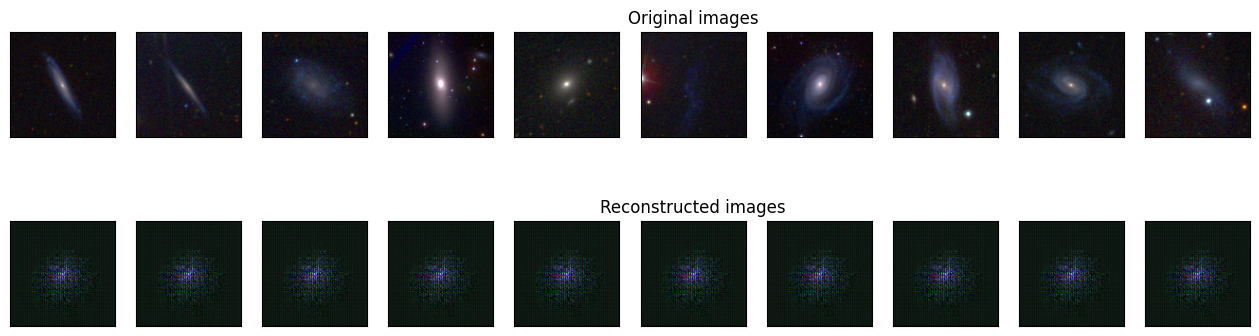

	 partial train loss (single batch): 0.014047
	 partial train loss (single batch): 0.014002
	 partial train loss (single batch): 0.014312
	 partial train loss (single batch): 0.013178
	 partial train loss (single batch): 0.013321
	 partial train loss (single batch): 0.013202
	 partial train loss (single batch): 0.013086
	 partial train loss (single batch): 0.013713
	 partial train loss (single batch): 0.012719
	 partial train loss (single batch): 0.012461
	 partial train loss (single batch): 0.012559
	 partial train loss (single batch): 0.012328
	 partial train loss (single batch): 0.012172
	 partial train loss (single batch): 0.012550
	 partial train loss (single batch): 0.012462

 EPOCH 2/50 	 train loss 0.01307398546487093 	 val loss 0.012592880055308342


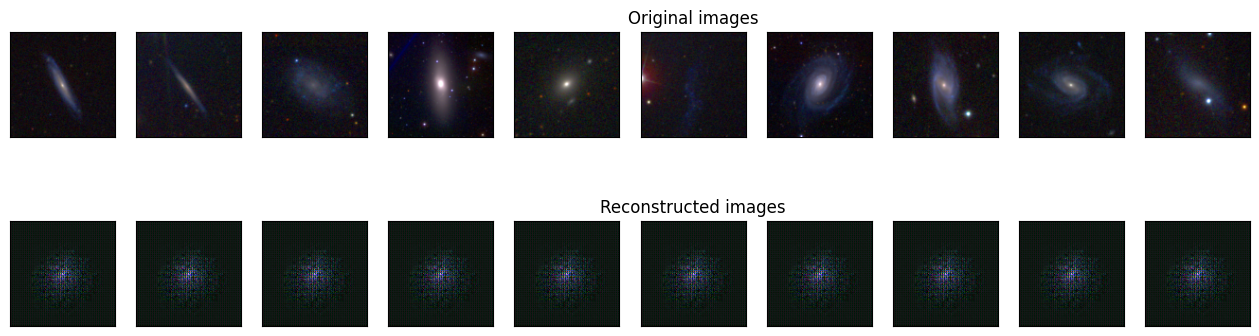

	 partial train loss (single batch): 0.012203
	 partial train loss (single batch): 0.011819
	 partial train loss (single batch): 0.011474
	 partial train loss (single batch): 0.011488
	 partial train loss (single batch): 0.011342
	 partial train loss (single batch): 0.011724
	 partial train loss (single batch): 0.011380
	 partial train loss (single batch): 0.011498
	 partial train loss (single batch): 0.010888
	 partial train loss (single batch): 0.011255
	 partial train loss (single batch): 0.011139
	 partial train loss (single batch): 0.010757
	 partial train loss (single batch): 0.010603
	 partial train loss (single batch): 0.011041
	 partial train loss (single batch): 0.011142

 EPOCH 3/50 	 train loss 0.011316887103021145 	 val loss 0.0110206613317132


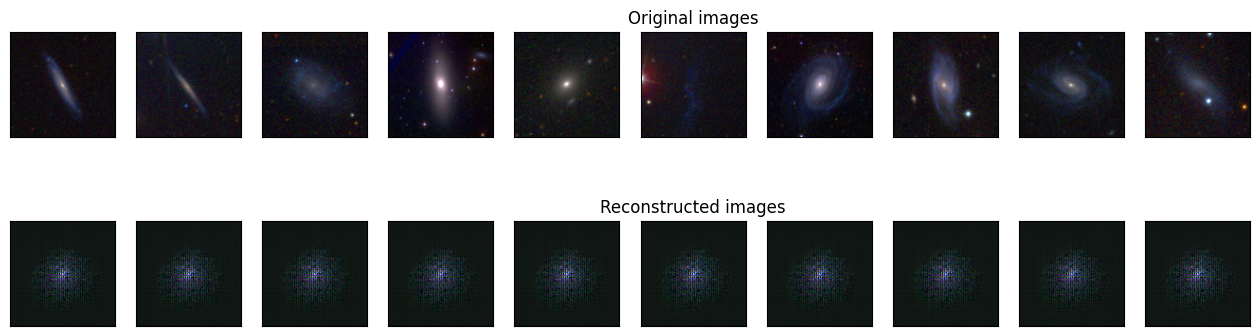

	 partial train loss (single batch): 0.010581
	 partial train loss (single batch): 0.011166
	 partial train loss (single batch): 0.010094
	 partial train loss (single batch): 0.009937
	 partial train loss (single batch): 0.010345
	 partial train loss (single batch): 0.010080
	 partial train loss (single batch): 0.010303
	 partial train loss (single batch): 0.009844
	 partial train loss (single batch): 0.009948
	 partial train loss (single batch): 0.010010
	 partial train loss (single batch): 0.009829
	 partial train loss (single batch): 0.009445
	 partial train loss (single batch): 0.009780
	 partial train loss (single batch): 0.009005
	 partial train loss (single batch): 0.009629

 EPOCH 4/50 	 train loss 0.009999768808484077 	 val loss 0.009839157573878765


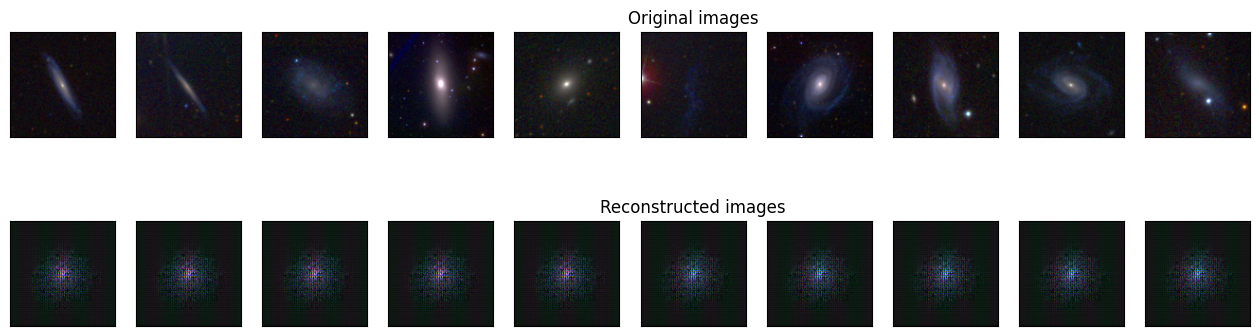

	 partial train loss (single batch): 0.008850
	 partial train loss (single batch): 0.009382
	 partial train loss (single batch): 0.009694
	 partial train loss (single batch): 0.008745
	 partial train loss (single batch): 0.009186
	 partial train loss (single batch): 0.009238
	 partial train loss (single batch): 0.008957
	 partial train loss (single batch): 0.009458
	 partial train loss (single batch): 0.009002
	 partial train loss (single batch): 0.009082
	 partial train loss (single batch): 0.008628
	 partial train loss (single batch): 0.009134
	 partial train loss (single batch): 0.008463
	 partial train loss (single batch): 0.008439
	 partial train loss (single batch): 0.008988

 EPOCH 5/50 	 train loss 0.00901657622307539 	 val loss 0.008947205729782581


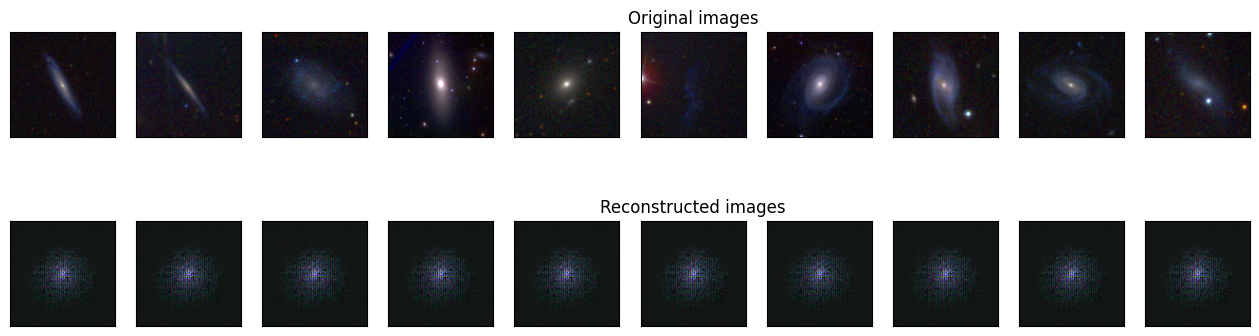

	 partial train loss (single batch): 0.008041
	 partial train loss (single batch): 0.008919
	 partial train loss (single batch): 0.008802
	 partial train loss (single batch): 0.008915
	 partial train loss (single batch): 0.008128
	 partial train loss (single batch): 0.007906
	 partial train loss (single batch): 0.007909
	 partial train loss (single batch): 0.008550
	 partial train loss (single batch): 0.008135
	 partial train loss (single batch): 0.008380
	 partial train loss (single batch): 0.008255
	 partial train loss (single batch): 0.007854
	 partial train loss (single batch): 0.008486
	 partial train loss (single batch): 0.007669
	 partial train loss (single batch): 0.007980

 EPOCH 6/50 	 train loss 0.008262076415121555 	 val loss 0.00827694684267044


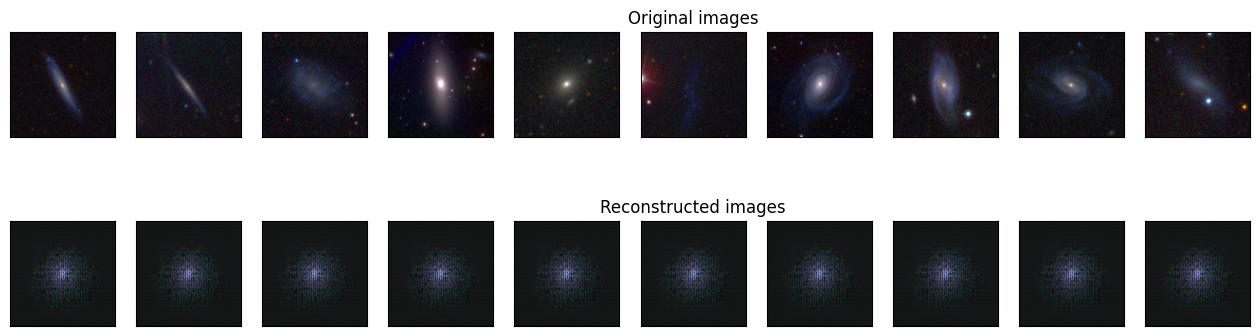

	 partial train loss (single batch): 0.007998
	 partial train loss (single batch): 0.007892
	 partial train loss (single batch): 0.008098
	 partial train loss (single batch): 0.007893
	 partial train loss (single batch): 0.007665
	 partial train loss (single batch): 0.007187
	 partial train loss (single batch): 0.008055
	 partial train loss (single batch): 0.007658
	 partial train loss (single batch): 0.007653
	 partial train loss (single batch): 0.007069
	 partial train loss (single batch): 0.008027
	 partial train loss (single batch): 0.007429
	 partial train loss (single batch): 0.008017
	 partial train loss (single batch): 0.007245
	 partial train loss (single batch): 0.007601

 EPOCH 7/50 	 train loss 0.007699226960539818 	 val loss 0.007778778672218323


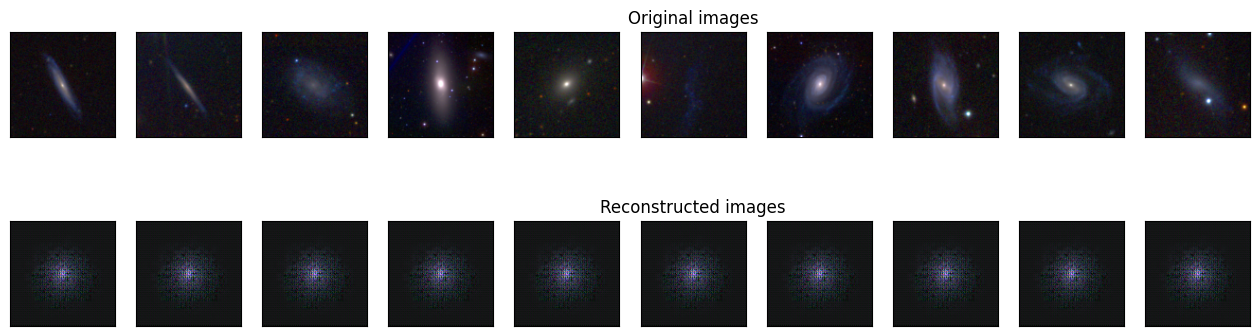

	 partial train loss (single batch): 0.007229
	 partial train loss (single batch): 0.007214
	 partial train loss (single batch): 0.007934
	 partial train loss (single batch): 0.007530
	 partial train loss (single batch): 0.007375
	 partial train loss (single batch): 0.007842
	 partial train loss (single batch): 0.006801
	 partial train loss (single batch): 0.006912
	 partial train loss (single batch): 0.007682
	 partial train loss (single batch): 0.007186
	 partial train loss (single batch): 0.006880
	 partial train loss (single batch): 0.007167
	 partial train loss (single batch): 0.007121
	 partial train loss (single batch): 0.007208
	 partial train loss (single batch): 0.006988

 EPOCH 8/50 	 train loss 0.007271339185535908 	 val loss 0.007384977303445339


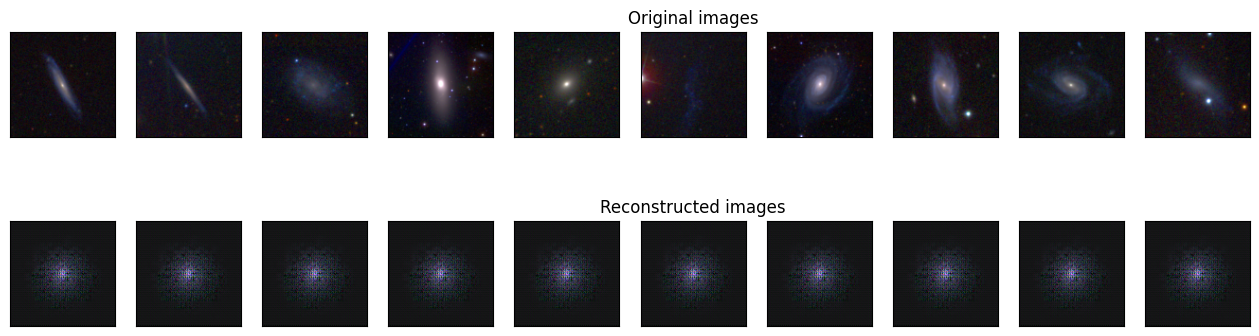

	 partial train loss (single batch): 0.007000
	 partial train loss (single batch): 0.006912
	 partial train loss (single batch): 0.007248
	 partial train loss (single batch): 0.007475
	 partial train loss (single batch): 0.006912
	 partial train loss (single batch): 0.006876
	 partial train loss (single batch): 0.007354
	 partial train loss (single batch): 0.006814
	 partial train loss (single batch): 0.006829
	 partial train loss (single batch): 0.006907
	 partial train loss (single batch): 0.006537
	 partial train loss (single batch): 0.006537
	 partial train loss (single batch): 0.006681
	 partial train loss (single batch): 0.007332
	 partial train loss (single batch): 0.006549

 EPOCH 9/50 	 train loss 0.006930851377546787 	 val loss 0.007072828244417906


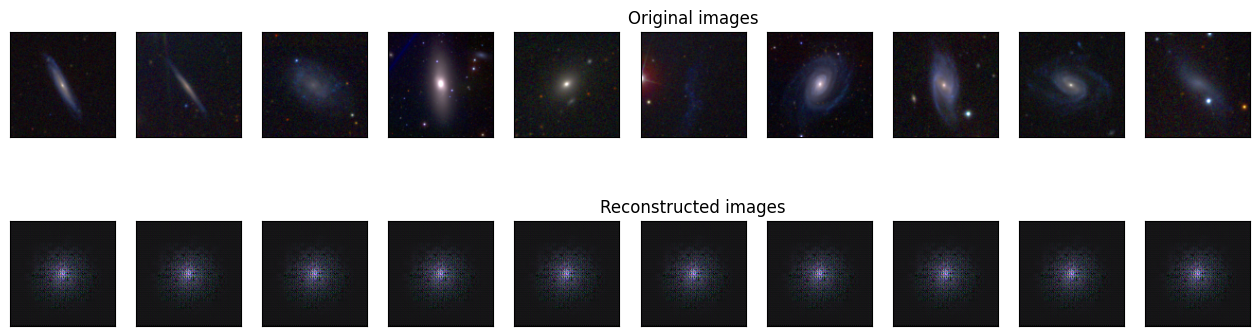

	 partial train loss (single batch): 0.008006
	 partial train loss (single batch): 0.006565
	 partial train loss (single batch): 0.007159
	 partial train loss (single batch): 0.006658
	 partial train loss (single batch): 0.006245
	 partial train loss (single batch): 0.006784
	 partial train loss (single batch): 0.006056
	 partial train loss (single batch): 0.006484
	 partial train loss (single batch): 0.006678
	 partial train loss (single batch): 0.006328
	 partial train loss (single batch): 0.006692
	 partial train loss (single batch): 0.006903
	 partial train loss (single batch): 0.006470
	 partial train loss (single batch): 0.006837
	 partial train loss (single batch): 0.006072

 EPOCH 10/50 	 train loss 0.006662634667009115 	 val loss 0.0068258121609687805


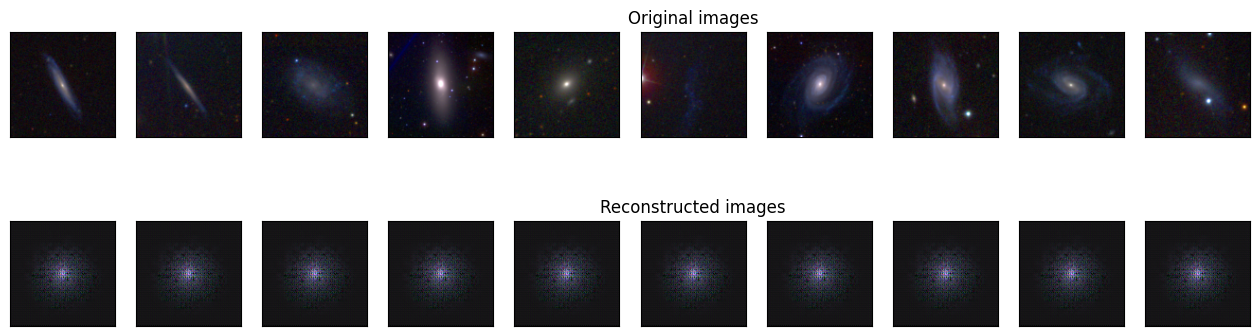

	 partial train loss (single batch): 0.006248
	 partial train loss (single batch): 0.006343
	 partial train loss (single batch): 0.006469
	 partial train loss (single batch): 0.006616
	 partial train loss (single batch): 0.006758
	 partial train loss (single batch): 0.006698
	 partial train loss (single batch): 0.006543
	 partial train loss (single batch): 0.006105
	 partial train loss (single batch): 0.006988
	 partial train loss (single batch): 0.006550
	 partial train loss (single batch): 0.006715
	 partial train loss (single batch): 0.006196
	 partial train loss (single batch): 0.006551
	 partial train loss (single batch): 0.005780
	 partial train loss (single batch): 0.006232

 EPOCH 11/50 	 train loss 0.006452828645706177 	 val loss 0.006650868803262711


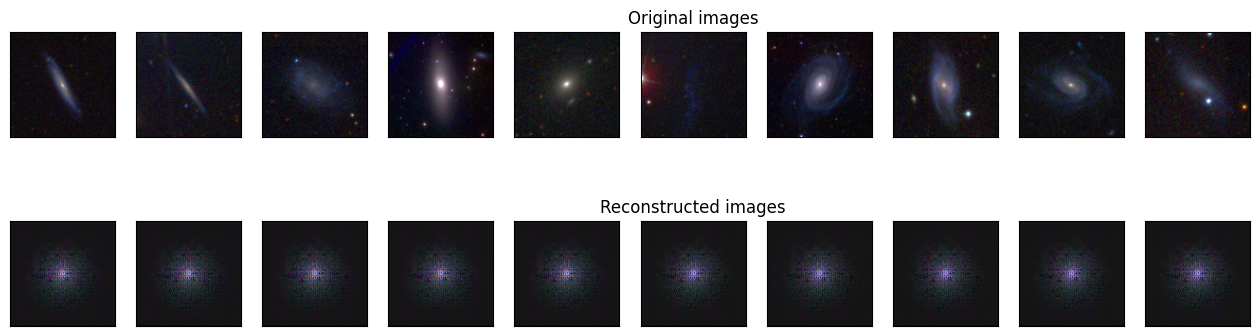

	 partial train loss (single batch): 0.006704
	 partial train loss (single batch): 0.005948
	 partial train loss (single batch): 0.006188
	 partial train loss (single batch): 0.006903
	 partial train loss (single batch): 0.005781
	 partial train loss (single batch): 0.006115
	 partial train loss (single batch): 0.006257
	 partial train loss (single batch): 0.006027
	 partial train loss (single batch): 0.006461
	 partial train loss (single batch): 0.006149
	 partial train loss (single batch): 0.007079
	 partial train loss (single batch): 0.006433
	 partial train loss (single batch): 0.005467
	 partial train loss (single batch): 0.006355
	 partial train loss (single batch): 0.006490

 EPOCH 12/50 	 train loss 0.006290540099143982 	 val loss 0.006484007928520441


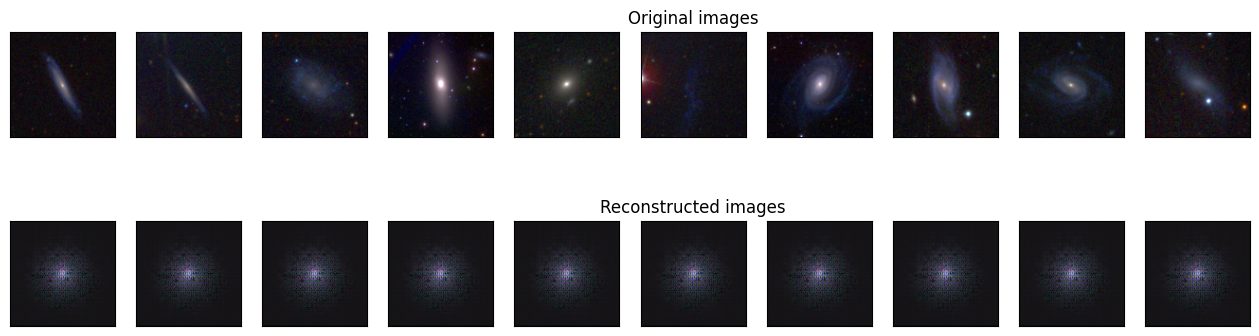

	 partial train loss (single batch): 0.006270
	 partial train loss (single batch): 0.006260
	 partial train loss (single batch): 0.006424
	 partial train loss (single batch): 0.006964
	 partial train loss (single batch): 0.005749
	 partial train loss (single batch): 0.006045
	 partial train loss (single batch): 0.006019
	 partial train loss (single batch): 0.005975
	 partial train loss (single batch): 0.005765
	 partial train loss (single batch): 0.005711
	 partial train loss (single batch): 0.006228
	 partial train loss (single batch): 0.006041
	 partial train loss (single batch): 0.006303
	 partial train loss (single batch): 0.006091
	 partial train loss (single batch): 0.006444

 EPOCH 13/50 	 train loss 0.006152577698230743 	 val loss 0.006350674666464329


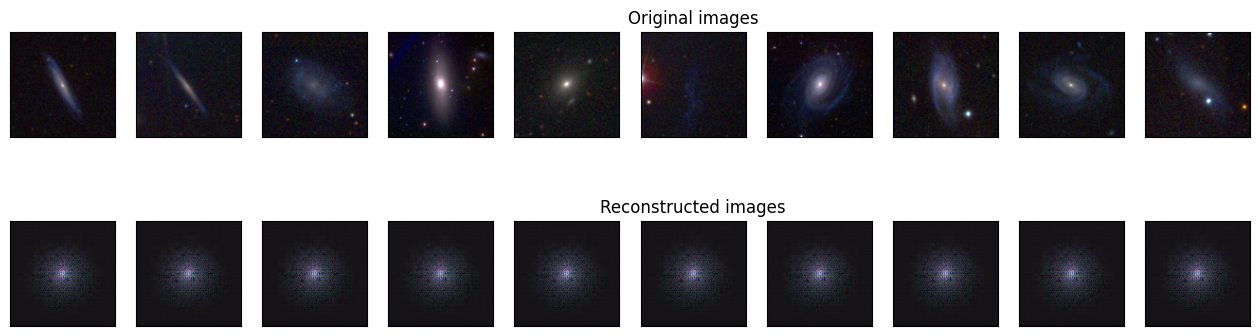

	 partial train loss (single batch): 0.006391
	 partial train loss (single batch): 0.005996
	 partial train loss (single batch): 0.006120
	 partial train loss (single batch): 0.006183
	 partial train loss (single batch): 0.006336
	 partial train loss (single batch): 0.006437
	 partial train loss (single batch): 0.005483
	 partial train loss (single batch): 0.006162
	 partial train loss (single batch): 0.005750
	 partial train loss (single batch): 0.006047
	 partial train loss (single batch): 0.005764
	 partial train loss (single batch): 0.006065
	 partial train loss (single batch): 0.006342
	 partial train loss (single batch): 0.005765
	 partial train loss (single batch): 0.005510

 EPOCH 14/50 	 train loss 0.0060234819538891315 	 val loss 0.006232544779777527


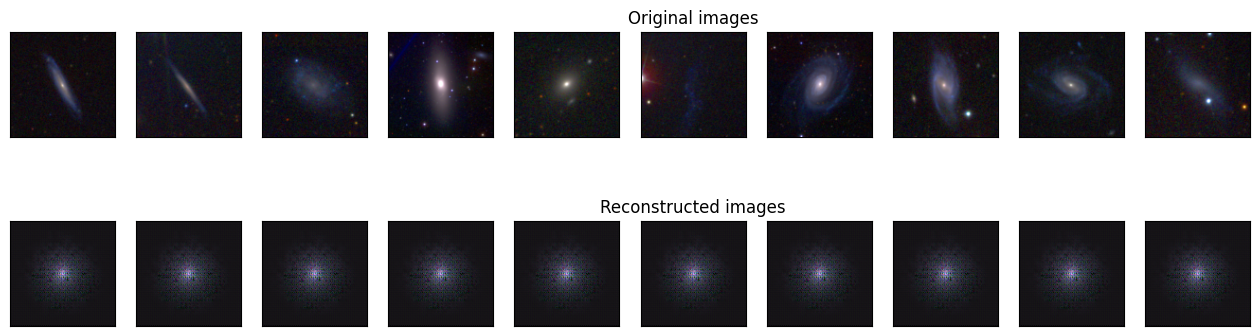

	 partial train loss (single batch): 0.005572
	 partial train loss (single batch): 0.005964
	 partial train loss (single batch): 0.006030
	 partial train loss (single batch): 0.006027
	 partial train loss (single batch): 0.006268
	 partial train loss (single batch): 0.005619
	 partial train loss (single batch): 0.006410
	 partial train loss (single batch): 0.005630
	 partial train loss (single batch): 0.005864
	 partial train loss (single batch): 0.006114
	 partial train loss (single batch): 0.006018
	 partial train loss (single batch): 0.005468
	 partial train loss (single batch): 0.006050
	 partial train loss (single batch): 0.005990
	 partial train loss (single batch): 0.005661

 EPOCH 15/50 	 train loss 0.005912276916205883 	 val loss 0.00611305795609951


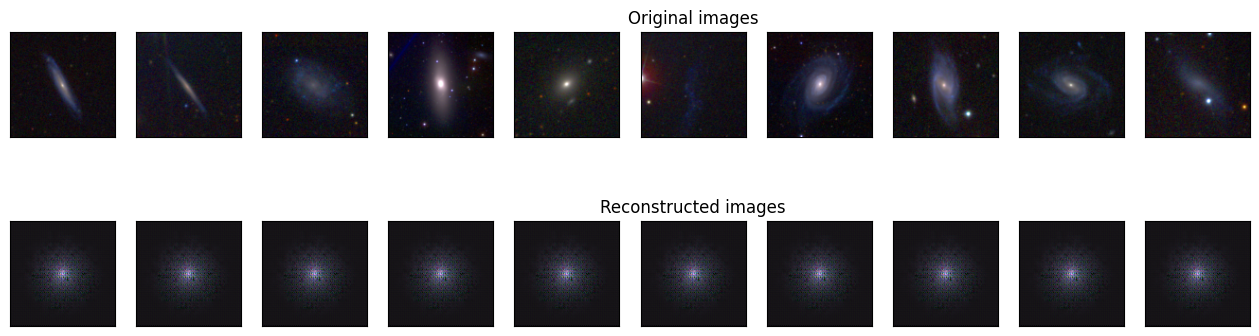

	 partial train loss (single batch): 0.006243
	 partial train loss (single batch): 0.005351
	 partial train loss (single batch): 0.005641
	 partial train loss (single batch): 0.005973
	 partial train loss (single batch): 0.005731
	 partial train loss (single batch): 0.006165
	 partial train loss (single batch): 0.005434
	 partial train loss (single batch): 0.005921
	 partial train loss (single batch): 0.006382
	 partial train loss (single batch): 0.005766
	 partial train loss (single batch): 0.005986
	 partial train loss (single batch): 0.005483
	 partial train loss (single batch): 0.005737
	 partial train loss (single batch): 0.005382
	 partial train loss (single batch): 0.005945

 EPOCH 16/50 	 train loss 0.005809352733194828 	 val loss 0.00600148132070899


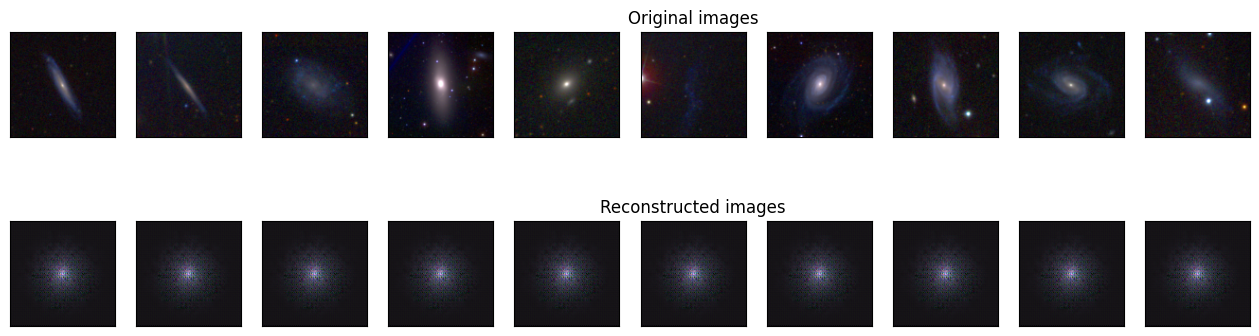

	 partial train loss (single batch): 0.005297
	 partial train loss (single batch): 0.005917
	 partial train loss (single batch): 0.006389
	 partial train loss (single batch): 0.005725
	 partial train loss (single batch): 0.006158
	 partial train loss (single batch): 0.005436
	 partial train loss (single batch): 0.005619
	 partial train loss (single batch): 0.005665
	 partial train loss (single batch): 0.005885
	 partial train loss (single batch): 0.005652
	 partial train loss (single batch): 0.005502
	 partial train loss (single batch): 0.005417
	 partial train loss (single batch): 0.005456
	 partial train loss (single batch): 0.005735
	 partial train loss (single batch): 0.005717

 EPOCH 17/50 	 train loss 0.005704634357243776 	 val loss 0.005916440859436989


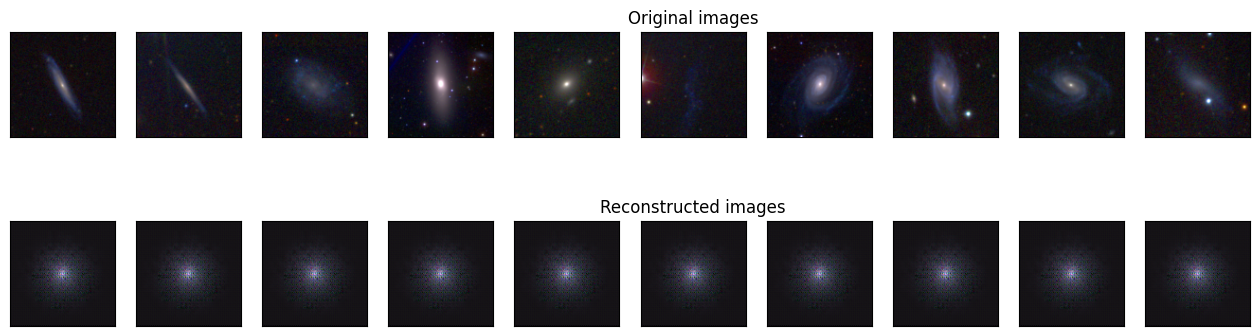

	 partial train loss (single batch): 0.006136
	 partial train loss (single batch): 0.005672
	 partial train loss (single batch): 0.005353
	 partial train loss (single batch): 0.005657
	 partial train loss (single batch): 0.005647
	 partial train loss (single batch): 0.005435
	 partial train loss (single batch): 0.005685
	 partial train loss (single batch): 0.005373
	 partial train loss (single batch): 0.005563


In [ ]:
num_epochs = 50
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

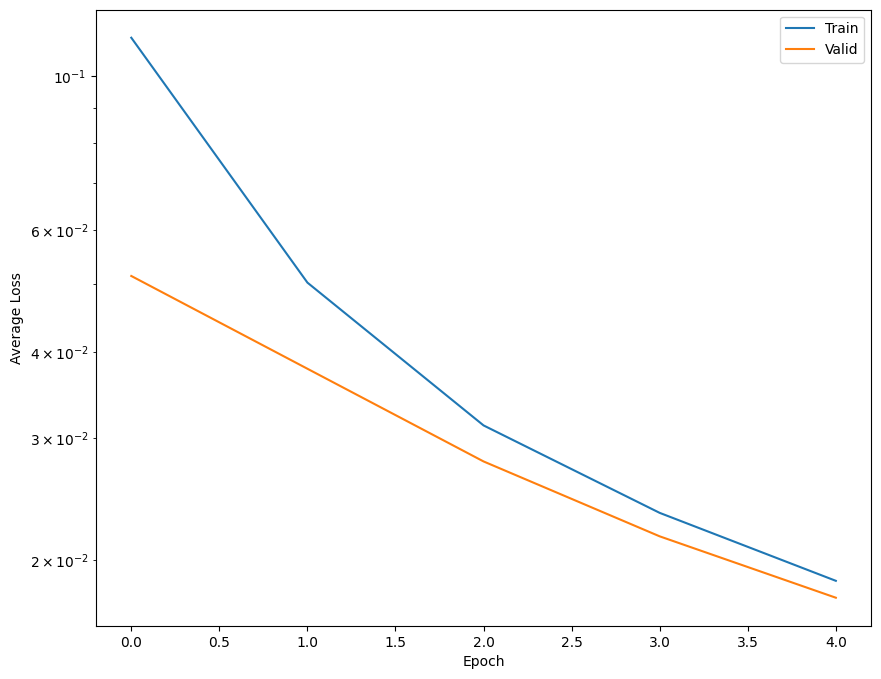

In [11]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

Generate new samples from the random latent code

tensor([-0.0872,  0.0014])
tensor([7.7495e-06, 5.1289e-06])


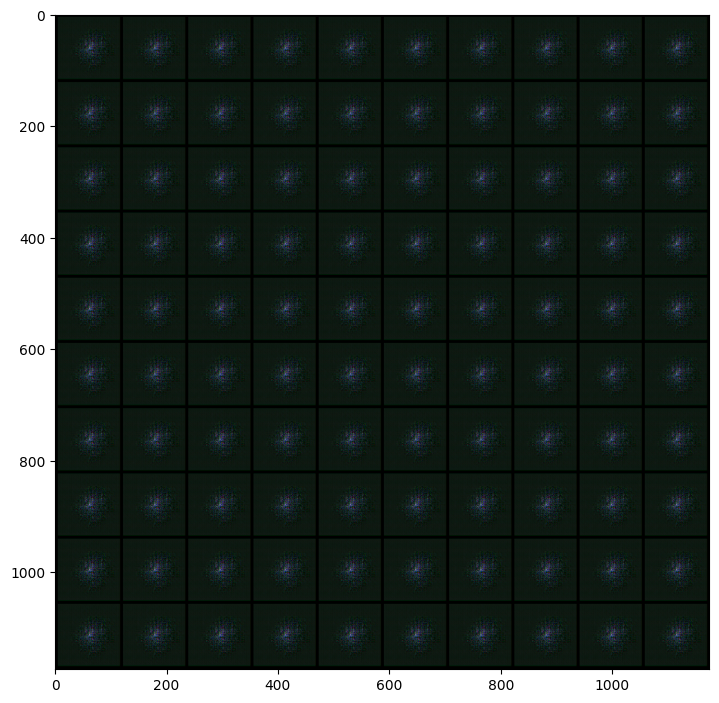

In [12]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs
    images = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = torch.clip(img_recon.cpu(),0,1)

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

Visualize the latent space with t-SNE

In [13]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample.unsqueeze(0).to(device)
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 458/458 [00:02<00:00, 165.00it/s]


Enc. Variable 0  Enc. Variable 1
0          -0.087230         0.001430
1          -0.087237         0.001426
2          -0.087238         0.001424
3          -0.087236         0.001426
4          -0.087241         0.001423
..               ...              ...
453        -0.087252         0.001415
454        -0.087237         0.001425
455        -0.087251         0.001416
456        -0.087232         0.001429
457        -0.087247         0.001419

[458 rows x 2 columns]

In [14]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', opacity=0.7)

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples) #.drop(['label'],axis=1)
fig = px.scatter(tsne_results, x=0, y=1,
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

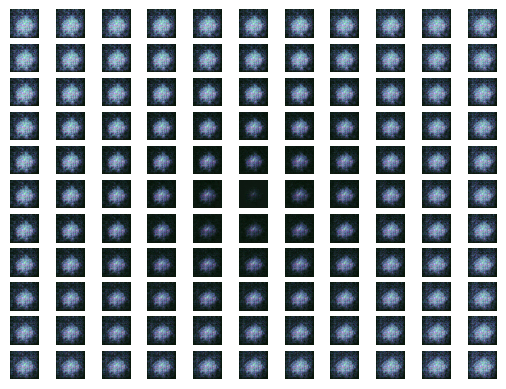

In [15]:
plt.figure()
for x in range(-5,6):
  for y in range(-5,6):
    coordinate = torch.tensor((6.0*x,6.0*y)).reshape(1,2)
    image = torch.swapaxes(torch.clip(decoder(coordinate).detach(),0, 1).cpu().reshape(3,112,112), 0, 2)
    ax = plt.subplot2grid((11,11),(x+5,y+5))
    plt.imshow(image)
    ax.axis('off')

In [16]:
#generate galaxy from face img


image_path = "Capybara.jpeg"
image = Image.open(image_path)#.convert("RGB")
image = efigi_transform(image).reshape(1,3,112,112)
image_transform = torch.clip(decoder(encoder(image)), 0, 1).detach()
image_transform = torch.swapaxes(image_transform.reshape(3,112,112), 0 , 2)

FileNotFoundError: [Errno 2] No such file or directory: 'Capybara.jpeg'

In [ ]:
plt.figure()
plt.imshow(image_transform)
